In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm.notebook import tqdm

import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
from torch.utils.data import DataLoader
from early_stopping.pytorchtools import EarlyStopping
from torch.utils import data
from glob import glob
import os as os
from PIL import Image
from sklearn.metrics import confusion_matrix,plot_confusion_matrix
from skimage import io
from sklearn import metrics

%matplotlib inline
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')


plt.rcParams['text.color'] = 'w'
plt.rcParams['xtick.color'] = 'w'
plt.rcParams['ytick.color'] = 'w'
plt.rcParams['axes.labelcolor'] = 'w'
font = {'family' : 'DejaVu Sans',
        'weight' : 'normal',
        'size'   : 14}
plt.rc('font', **font)

In [2]:
number_of_frames=16
slice={16:(0,0,0), 
       32:(0,0,0),
      64:(0,0,0),
      128:(0,0,0),
      256:(0,0,0)}

class_dict = {0:"LSP",1:"LSA"}

In [3]:
class MModeDataset(data.Dataset):

    def __init__(self,
                 root_fp='/media/miro/4tb_cached/usg_data/base_dataset/mmode/',
                 transform=None,
                 number_of_frames=32):
        super(MModeDataset, self).__init__()
        self.transform = transform

        flow_fp = os.path.join(root_fp, "{:d}".format(number_of_frames))
        self.image_list = sorted(glob(os.path.join(flow_fp, '*/*/*.png')))
        self.classes = np.zeros((len(self.image_list)))
        self.identifiers = list()
        self.sample_identifiers = list()
        self.data = list()
        for idx, fp in enumerate(tqdm(self.image_list)):
            if "lung_sliding_absence" in self.image_list[idx]:
                self.classes[idx] = 1
            self.identifiers += [os.path.dirname(self.image_list[idx])]
            self.sample_identifiers += [os.path.basename(self.image_list[idx])]
            #self.data += [Image.open(self.image_list[idx])]            
            self.data += [io.imread(self.image_list[idx])]

    def __getitem__(self, index):
        img = self.data[index]
        if self.transform:
            img = self.transform(img)

        return img, self.classes[index], self.identifiers[index], self.sample_identifiers[index]

    def __len__(self):
        return len(self.image_list)

In [4]:
class DataGenDataset(data.Dataset):

    def __init__(self,
                 root_fp='/media/miro/4tb_cached/usg_data/base_dataset/',
                 mask_dir_name="lung_mask_ce",
                 transform=None,
                 number_of_frames=32,
                 step = 16,
                 load2ram = False):
        super(DataGenDataset, self).__init__()
        self.transform = transform
        self.number_of_frames = number_of_frames
        self.step = step

        self.image_list = sorted(glob(os.path.join(root_fp, 'frames/*/*/*.png')))
        self.lung_mask_list = [fp.replace("/frames/","/lung_mask_ce/") for fp in self.image_list]
        self.pleura_mask_list = [fp.replace("/frames/","/pleura_mask_ce/") for fp in self.image_list]
        self.rib_mask_list = [fp.replace("/frames/","/rib_mask_ce/") for fp in self.image_list]

        self.classes, self.identifiers, self.frame_list, self.data, self.mask_data = \
            dict(), list(), list(), dict(), dict()

        nos = len(self.image_list)
        idx = 0
        while idx < nos:
            if idx + self.number_of_frames < nos:
                if os.path.dirname(self.image_list[idx]) in os.path.dirname(self.image_list[idx + self.number_of_frames]):
                    self.frame_list += [self.image_list[idx:idx + self.number_of_frames]]
                    self.identifiers += [os.path.dirname(self.image_list[idx])]
            idx = idx+self.step

        for idx in tqdm(range(nos)):
            if "lung_sliding_absence" in self.image_list[idx]:
                self.classes[self.image_list[idx]] = 1
            else:
                self.classes[self.image_list[idx]] =  0

            if load2ram:
                self.data[self.image_list[idx]] = io.imread(self.image_list[idx])
                #self.mask_data[self.image_list[idx]] = io.imread(self.mask_list[idx])
            else:
                self.data[self.image_list[idx]] = Image.open(self.image_list[idx])
                #self.mask_data[self.image_list[idx]] = Image.open(self.mask_list[idx])


    def __getitem__(self, index):
        frames = self.frame_list[index]

        img = np.zeros((self.number_of_frames,480,480))
        for idx, frame in enumerate(frames):
            img[idx,:,:] = np.array(self.data[frame])

        mask_lung =  io.imread(frames[0].replace("/frames/","/lung_mask_ce/"))
        mask_pleura =  io.imread(frames[0].replace("/frames/","/pleura_mask_ce/"))
        mask_rib =  io.imread(frames[0].replace("/frames/","/rib_mask_ce/"))

        if self.transform:
            img = self.transform(img)

        return img,self.identifiers[index], mask_lung,mask_pleura,mask_rib, self.classes[frames[0]]

    def __len__(self):
        return len(self.frame_list)
    
    def get_identifier_sequence(self, keys):
        indices = list()
        for key in keys:
            indices.extend([idx for idx,identifier in enumerate(self.identifiers) if key in identifier])
        return indices
        
    def get_class_vector(self, indices):
        im_classes = []
        for index in indices:
            if "lung_sliding_absence" in self.image_list[index]:
                im_classes += [1]
            else:
                im_classes += [0]
        return np.array(im_classes)    

  0%|          | 0/94454 [00:00<?, ?it/s]

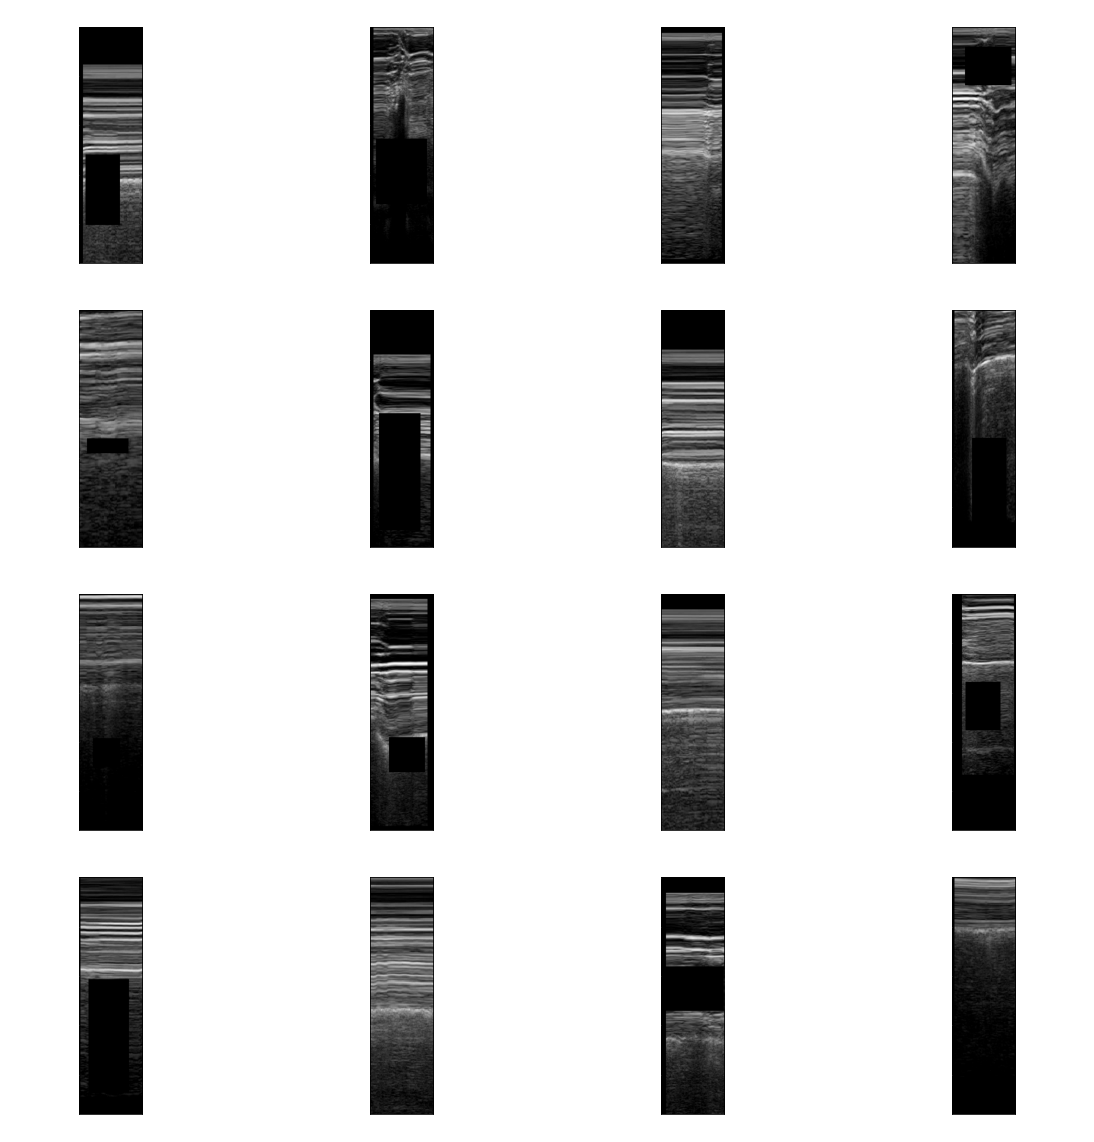

In [5]:
class Gray2Rgb(torch.nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, img):
        return torch.cat((img, img, img),dim=0)

min_transform =torchvision.transforms.Compose([
                                    #torchvision.transforms.Resize((256,256)),
                                    torchvision.transforms.ToTensor(),
                                    Gray2Rgb()
                                    ])
transform = torchvision.transforms.Compose([
                                    #torchvision.transforms.Resize((480,256)),
                                    torchvision.transforms.ToTensor(),
                                    torchvision.transforms.RandomAffine(0,(0.1,0.2),(0.8,1.25)),
                                    torchvision.transforms.RandomErasing(),
                                    Gray2Rgb()
                                    ])

dataset = MModeDataset(root_fp ="/home/jin/Documents/miro/data/base_dataset/mmode",number_of_frames=128,transform=transform)
fig, axs = plt.subplots(4, 4,figsize=(20,20))
sample = np.random.randint(0,len(dataset),64)

for i in range(16):
    img, target, _, _ = dataset.__getitem__(sample[i])
    img = img.permute(1,2,0)
    axs[i//4,i%4].imshow(img)
    axs[i//4,i%4].set_title("{} min: {:.2f} max: {:.2f}".format(class_dict[int(target)],torch.min(img),torch.max(img)))

In [6]:
import pandas as pd
from skimage.measure import label, regionprops_table
from skimage.morphology import binary_opening,rectangle
import skimage as sk

def return_slice_coords(mask_lung,mask_pleura,mask_rib,ideal_slice=(0,0,0)):
    new_slice_lung,new_slice_pleura,new_slice_rib = 240,240,240

    im  = binary_opening(sk.transform.resize(mask_lung,(480,480)),rectangle(5,5))
    label_image = label(im)
    regions = regionprops_table(label_image,properties=('label','area','centroid'))
    if np.max(label_image)>0:
        x_centroid = regions['centroid-1'][0]
        if x_centroid + ideal_slice[1] < 480:
            new_slice_lung =x_centroid + ideal_slice[1]
        else:
            new_slice_lung = x_centroid

    im  = binary_opening(sk.transform.resize(mask_pleura,(480,480)),rectangle(5,5))
    label_image = label(im)
    if np.max(label_image)>0:
        regions = regionprops_table(label_image,properties=('label','area','centroid'))
        x_centroid = regions['centroid-1'][0]
        if x_centroid + ideal_slice[1] <480:
            new_slice_pleura =x_centroid + ideal_slice[1]
        else:
            new_slice_pleura = x_centroid

    im  = binary_opening(sk.transform.resize(mask_rib,(480,480)),rectangle(5,5))
    label_image = label(im)
    if np.max(label_image)>0:
        regions = regionprops_table(label_image,properties=('label','area','centroid'))
        if np.max(label_image)>1:
            df = pd.DataFrame(regions)
            x=0
            for zz in range(2):
                index = df['area'].idxmax()
                x_centroid = df['centroid-1'][index]
                x= x+x_centroid
                df = df.drop(labels=index, axis=0)
            x_centroid= x/2
            if x_centroid + ideal_slice[1] <480:
                new_slice_rib =x_centroid + ideal_slice[2]
            else:
                new_slice_rib = x_centroid

    return new_slice_lung,new_slice_pleura,new_slice_rib

def random_split_by_unique_identifier(dataset, split, number_of_frames):
    df = pd.DataFrame((dataset.identifiers))
    identifiers = df[0].to_numpy()
    unique_identifiers = np.unique(identifiers)
    samples_count = len(unique_identifiers)
    random_samp = np.random.permutation(np.arange(0,samples_count,1))

    split_one_end = int(split[0]*samples_count)
    split_two_end = split_one_end+int(split[1]*samples_count)
    random_split_1 = random_samp[0:split_one_end]
    random_split_2 = random_samp[split_one_end:split_two_end]
    random_split_3 = random_samp[split_two_end:]
    
    f = open("split_"+str(number_of_frames)+".txt", "w")

    random_splits =  [random_split_1,random_split_2,random_split_3]
    
    for i, random_split in enumerate(random_splits):
        indices= list()
        
        for idx in random_split:
            rows = unique_identifiers[idx] == df.iloc[:,0]
            matched_indices =np.where(rows.to_numpy())[0]
            indices.extend(matched_indices)
            
            f.write(unique_identifiers[idx].split('/')[-1]+"\n")
        if i==0:
            f.write("\n")
            train_ds = data.Subset(dataset,np.random.permutation(indices))
        elif i==1:
            f.write("\n")
            valid_ds = data.Subset(dataset,np.random.permutation(indices))
        else:
            f.write("\n")
            test_ds= data.Subset(dataset,np.random.permutation(indices))
    f.close()
    return train_ds, valid_ds, test_ds

from sklearn.model_selection import KFold

def create_K_fold_unqique_idents(dataset, training2valid_ratio=0.5, K=4):
    df = pd.DataFrame((dataset.identifiers))
    identifiers = df[0].to_numpy()
    unique_identifiers = np.unique(identifiers)
    samples_count = len(unique_identifiers)

    random_samp = np.random.permutation(np.arange(0,samples_count,1))

    kf = KFold(n_splits=K)
    train_indices = []
    valid_indices = []
    test_indices = []
    test_ids = []
    
    for train_index, test_index in kf.split(random_samp):
        split = int(len(train_index)*training2valid_ratio)
        train_indices.append(random_samp[train_index[0:split]])
        valid_indices.append(random_samp[train_index[split:len(train_index)]])
        test_indices.append(random_samp[test_index])
        test_ids.append(unique_identifiers[random_samp[test_index]])

    return np.array([train_indices,valid_indices,test_indices],dtype=object), test_ids

def evaluate_on_slices_with_correction(model,dataset,test_identifiers,correction):
    y_gts = list()
    y_preds = list()
    identifiers = list()
    for idx in tqdm(dataset.get_identifier_sequence(test_identifiers)):
        img,identifier, mask_lung,mask_pleura,mask_rib,y = dataset.__getitem__(idx)
        new_slice_lung,new_slice_pleura,new_slice_rib = return_slice_coords(mask_lung,mask_pleura,mask_rib,ideal_slice=correction)
        im =torch.tensor(img[:,:,[int(new_slice_lung),int(new_slice_pleura),int(new_slice_rib)]],dtype=torch.float32).permute(2,1,0)
        input_data = torch.stack((im,im,im),1).cuda(device)/255
        out =  model(input_data)
        _,y_pred = torch.max(out,1)
        y_gts.extend(np.repeat(y,3))
        y_preds.extend(y_pred.detach().cpu().numpy())
        identifiers.extend([identifier,identifier,identifier])
    return identifiers, y_gts, y_preds


def create_subsets_for_K(dataset, splits, K_n):
    random_splits = splits[:,K_n]
    df = pd.DataFrame((dataset.identifiers))
    identifiers = df[0].to_numpy()
    unique_identifiers = np.unique(identifiers)

    for i, random_split in enumerate(random_splits):
        indices= list()
        for idx in random_split:
            if idx < len(unique_identifiers):
                rows = unique_identifiers[idx] == df.iloc[:,0]
                matched_indices = np.where(rows.to_numpy())[0]
                indices.extend(matched_indices)
        if i==0:
            train_ds = data.Subset(dataset,np.random.permutation(indices))
        elif i==1:
            valid_ds = data.Subset(dataset,np.random.permutation(indices))
        else:
            test_ds= data.Subset(dataset,np.random.permutation(indices))
    return train_ds, valid_ds, test_ds

def return_ids_from_filepaths(test_id):
    return [fp.split('/')[-1] for fp in test_id]

In [7]:
batch_size =  64
splits, test_ids = create_K_fold_unqique_idents(dataset=dataset,training2valid_ratio=0.6, K=4)
train_ds, valid_ds, test_ds = create_subsets_for_K(dataset,splits,K_n=0)

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_ds, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False)

In [8]:
def train(model, n_epochs,train_loader,valid_loader,criterion,optimizer,scheduler=None,early_stop_count=0,identifier = "net.pth"):
    batch_train_losses = []
    avg_train_losses = []
    
    avg_valid_acc = []
    batch_valid_losses = []
    avg_valid_losses = []

    early_stopping = EarlyStopping(patience=early_stop_count, verbose=True, path=identifier)

    for epoch in range(1, n_epochs + 1):
        train_losses = []
        valid_losses = []
        valid_accs = []

        model.train() # prep model for training
        for input_data, classes,_,_ in tqdm(train_loader):
            data = input_data.to(device)
            target = classes.long().to(device)

            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            train_losses.append(loss.item())

        model.eval()
        with torch.no_grad():
            for input_data, classes,_,_ in tqdm(valid_loader):
                data = input_data.to(device)
                target = classes.long().to(device)

                output = model(data)
                loss = criterion(output, target)
                valid_losses.append(loss.item())

                _, pred = torch.max(output, 1)

                valid_accs.append(np.sum(target.cpu().numpy() == pred.cpu().numpy()) / pred.shape[0])



        train_loss = np.average(train_losses)
        valid_loss = np.average(valid_losses)
        valid_acc = np.average(valid_accs)

        if scheduler:
            scheduler.step()

        avg_valid_acc.append(valid_acc)
        batch_train_losses.extend(train_losses)
        batch_valid_losses.extend(valid_losses)
        avg_valid_losses.append(valid_loss)
        avg_train_losses.append(train_loss)
        
        epoch_len = len(str(n_epochs))

        print_msg = (f'[{epoch:>{epoch_len}}/{n_epochs:>{epoch_len}}] ' +
                     f'train_loss: {train_loss:.5f} ' +
                     f'valid_loss: {valid_loss:.5f} '
                     f'valid_acc: {valid_acc*100:2.2f} %')
        if scheduler:
            print_msg = print_msg + " lr: {:.5f}".format(scheduler.get_last_lr()[0])
        print(print_msg)

        if early_stop_count:
            early_stopping(valid_loss, model)

            if early_stopping.early_stop:
                model.load_state_dict(torch.load(identifier))
                print("Early stopping")
                break
    if early_stop_count:    
        model.load_state_dict(torch.load(identifier))
        
    return avg_train_losses, avg_valid_losses, batch_train_losses, batch_valid_losses, model

In [9]:
from scipy.interpolate import interp1d
from sklearn import metrics
import pandas as pd

 
def return_string_metrics(y_true,y_pred):

    tn, fp, fn, tp  = confusion_matrix(y_true,y_pred).ravel()

    acc = metrics.accuracy_score(y_true,y_pred)
    bal_acc = metrics.balanced_accuracy_score(y_true, y_pred)
    f1 = metrics.f1_score(y_true, y_pred)
    precision = metrics.precision_score(y_true, y_pred)
    recall = metrics.recall_score(y_true, y_pred)
    spec = tn/(tn+fp)
    return "{}\t{}\t{}\t{}\t{:.4f}\t{:.4f}\t{:.4f}\t{:.4f}\t{:.4f}\t{:.4f}\t".format(tp,fp,fn,tn,acc, bal_acc, f1, precision, recall,spec)

def return_aggregated_metrics(identifiers_list,y_true,y_pred):
    df = pd.DataFrame((identifiers_list,y_true,y_pred))
    df = df.T
    identifiers = df[0].to_numpy()
    unique_identifiers = np.unique(identifiers)
    y_gt = df[1].to_numpy()
    y_pred = df[2].to_numpy()

    acc_stack = []
    lsp_acc_stack = []
    lsa_acc_stack = []
    nos_stack = []
    for unique_identifier in unique_identifiers:
        rows = unique_identifier == identifiers
        sample_gt = y_gt[rows]
        sample_pred = y_pred[rows]

        acc = np.sum(sample_gt==sample_pred)/len(sample_gt)
        nos = len(sample_gt)

        nos_stack+=[nos]
        acc_stack+=[acc]
        if np.sum(sample_gt) == 0:
            lsp_acc_stack+=[acc]
        else:
            lsa_acc_stack+=[acc]

        #print(str(len(sample_gt)) +" " + "{:.2f}".format(acc) +" "+ str(acc>0.5) +" "+ str(acc>0.75)+" "+ str(acc>0.9))
    acc_stack = np.array(acc_stack)

    nos_avg = np.sum(nos_stack)/len(nos_stack)
    acc_50 = np.sum(acc_stack>0.5)/len(acc_stack)
    acc_75 = np.sum(acc_stack>0.75)/len(acc_stack)
    acc_90 = np.sum(acc_stack>0.9)/len(acc_stack)
    
    y_gt_data = []
    y_pred_data = []

    y_gt_data.extend(np.zeros((len(lsp_acc_stack),)))
    y_pred_data.extend(np.array(lsp_acc_stack)<0.5)

    y_gt_data.extend(np.ones((len(lsa_acc_stack),)))
    y_pred_data.extend(np.array(lsa_acc_stack)>=0.5)
        
    #plt.boxplot((lsp_acc_stack,lsa_acc_stack),labels=("Lung sliding presence", "Lung sliding absence"))
    
    return "{:.4f}\t{:.4f}\t{:.4f}\t{}".format(acc_50,acc_75,acc_90,return_string_metrics(y_gt_data, y_pred_data))

def get_test_output(model, test_loader,identifier=""):
    y_gts = np.array([])
    y_preds = np.array([])
    identifiers = list()
    model.eval()
    f = open("test_results_"+identifier+".txt", "w")
    with torch.no_grad():
        for input_data, classes,identifier,sample_identifiers in tqdm(test_loader):
            x = input_data.to(device)
            y = classes.long().to(device)
            output = model(x)
            _, pred = torch.max(output, 1)
        
            y_gts = np.hstack((y_gts, y.cpu().numpy()))
            y_preds = np.hstack((y_preds, pred.cpu().numpy()))
            identifiers.extend(identifier)
            for  ident, sample_identifier,y_gt, y_pred in zip(identifier,sample_identifiers,y.cpu().numpy(),pred.cpu().numpy()):
                f.write("{} {} {} {}\n".format(ident,sample_identifier,y_gt,y_pred))

    f.close()        
    return  identifiers,y_gts,y_preds

def visualize_loss(avg_valid_losses,avg_train_losses):
    plt.figure()

    xx = np.arange(0,len(avg_valid_losses),1)
    xx2 = np.arange(0,len(avg_train_losses),1)

    y_valid = np.array(avg_valid_losses)
    y_train =  np.array(avg_train_losses)

    f_valid = interp1d(xx, y_valid)
    f_train = interp1d(xx2, y_train)
    if len(avg_valid_losses) < len(avg_train_losses):
        plt.plot(xx, f_valid(xx))
        plt.plot(xx, f_train(xx),color='red')
    else:
        plt.plot(xx2, f_valid(xx2))
        plt.plot(xx2, f_train(xx2),color='red')
    plt.legend(("Validation Loss","Training Loss"),labelcolor='black')
    plt.xlabel("Batches")
    plt.ylabel("Loss Value")
    plt.title("Loss of validation and training set")
    plt.show()

In [10]:
from prettytable import PrettyTable

def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        param = parameter.numel()
        table.add_row([name, param])
        total_params+=param
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params

In [11]:
torch.__version__

'1.8.1+cu111'

In [12]:
from torchsummary import summary
model = torchvision.models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features

model.fc = nn.Sequential(
    nn.Dropout(0.5),
    nn.Linear(num_ftrs, 2)
)

#model = Net()
model = model.cuda(device)
#model = nn.DataParallel(model, device_ids=None)

optimizer = torch.optim.Adam(model.parameters(),
                         lr=0.001)

summary(model,input_size=(3,480,128))

input_data,_,_,_ = next(iter(train_loader))
output = model(input_data.cuda(device))
print(output.shape)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 64, 240, 64]           9,408
       BatchNorm2d-2          [-1, 64, 240, 64]             128
              ReLU-3          [-1, 64, 240, 64]               0
         MaxPool2d-4          [-1, 64, 120, 32]               0
            Conv2d-5          [-1, 64, 120, 32]          36,864
       BatchNorm2d-6          [-1, 64, 120, 32]             128
              ReLU-7          [-1, 64, 120, 32]               0
            Conv2d-8          [-1, 64, 120, 32]          36,864
       BatchNorm2d-9          [-1, 64, 120, 32]             128
             ReLU-10          [-1, 64, 120, 32]               0
       BasicBlock-11          [-1, 64, 120, 32]               0
           Conv2d-12          [-1, 64, 120, 32]          36,864
      BatchNorm2d-13          [-1, 64, 120, 32]             128
             ReLU-14          [-1, 64, 

In [13]:
def extract_weights(counts, device):
    weights = np.sum(counts)/ (counts.shape[0] * counts)
    return torch.tensor(weights,dtype=torch.float).to(device)

Weights are:  tensor([0.3140, 0.6860], device='cuda:0')


Text(0.5, 1.0, 'Class Distribution')

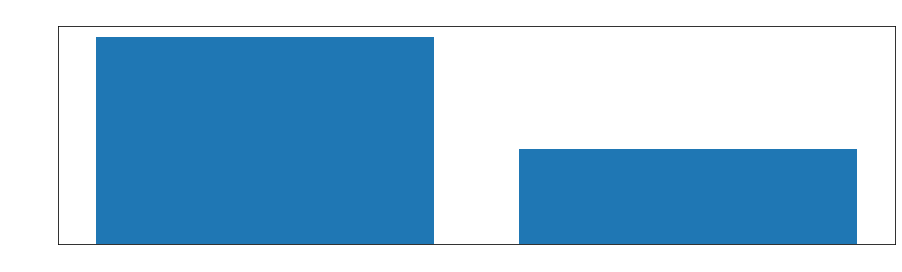

In [14]:
hist_val,hist_x = np.histogram(dataset.classes,[-0.5,0.5,1.5])
weights  = extract_weights(hist_val,device)
weights = weights/torch.sum(weights)
print("Weights are: ",weights)
plt.figure(figsize=(15,4))
plt.bar(hist_x[0:len(hist_x)-1],hist_val,tick_label=[v for _,v in class_dict.items()])
plt.title("Class Distribution")

In [ ]:
epochs = 15
correction = (0, 0,  0)
nofs = [8,128]
steps = [8, 8, 8] 
K=3
repetition_count = 10

for number_of_frames,step in zip(nofs,steps):
    dataset = MModeDataset(root_fp ="/home/jin/Documents/miro/data/base_dataset/mmode",number_of_frames=number_of_frames,transform=transform)
    dataset_test = DataGenDataset(root_fp ="/home/jin/Documents/miro/data/base_dataset/",number_of_frames=number_of_frames, step = step,load2ram=True)
    
    weights  = extract_weights(hist_val,device)
    weights = weights/torch.sum(weights)
    print("Weights are: ",weights)
    for repetition in range(repetition_count):
        splits, test_ids = create_K_fold_unqique_idents(dataset=dataset,training2valid_ratio=0.6, K=K)
        for idx in range(K):

            model = torchvision.models.resnet18(pretrained=True)
            num_ftrs = model.fc.in_features

            model.fc = nn.Sequential(
                nn.Dropout(0.5),
                nn.Linear(num_ftrs, 2)
            )

            #model = Net()
            model = model.cuda(device)
            #model = nn.DataParallel(model, device_ids=None)

            optimizer = torch.optim.Adam(model.parameters(),
                                     lr=0.001)

            train_ds, valid_ds, test_ds = create_subsets_for_K(dataset,splits,K_n=idx)

            train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
            valid_loader = DataLoader(valid_ds, batch_size=batch_size, shuffle=False)
            test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False)

            criterion = torch.nn.CrossEntropyLoss(weight=weights)
            dataset.transform = transform

            train_loss, valid_loss,batch_train_losses, batch_valid_losses, model = train(model,
                                                                                        epochs,
                                                                                        train_loader=train_loader,
                                                                                        valid_loader=valid_loader,
                                                                                        criterion=criterion,
                                                                                        optimizer=optimizer,
                                                                                        early_stop_count=3,
                                                                                        identifier = "net_{}.pth".format(number_of_frames))
            dataset.transform = min_transform
            
            identifiers,y_gts,y_preds = get_test_output(model, test_loader=test_loader,identifier=str(number_of_frames))
            
            identifiers2,y_gts2,y_preds2  = evaluate_on_slices_with_correction(model,dataset_test,return_ids_from_filepaths(test_ids[idx]),correction)
        
            print("{}-FOLD with {}".format(idx,number_of_frames) + return_string_metrics( y_gts,y_preds))
            fh = open("data/log_final_10x3_1.txt","a")
            fh.write(str("{}\t{}\t{}\t{}{}{}{}\n".format(repetition,
                                                           idx, 
                                                           number_of_frames, 
                                                           return_string_metrics(y_gts,y_preds), 
                                                           return_aggregated_metrics(identifiers,y_gts,y_preds),
                                                           return_string_metrics(y_gts2,y_preds2), 
                                                           return_aggregated_metrics(identifiers2,y_gts2,y_preds2))))
            fh.close()


  0%|          | 0/584716 [00:00<?, ?it/s]

  0%|          | 0/17386 [00:00<?, ?it/s]

Weights are:  tensor([0.3140, 0.6860], device='cuda:0')


  0%|          | 0/3298 [00:00<?, ?it/s]

  0%|          | 0/2898 [00:00<?, ?it/s]

[ 1/15] train_loss: 0.08833 valid_loss: 3.20967 valid_acc: 35.19 %
Validation loss decreased (inf --> 3.209668).  Saving model ...


  0%|          | 0/3298 [00:00<?, ?it/s]

  0%|          | 0/2898 [00:00<?, ?it/s]

[ 2/15] train_loss: 0.03016 valid_loss: 3.62213 valid_acc: 42.81 %
EarlyStopping counter: 1 out of 3


  0%|          | 0/3298 [00:00<?, ?it/s]

  0%|          | 0/2898 [00:00<?, ?it/s]

[ 3/15] train_loss: 0.02058 valid_loss: 3.46383 valid_acc: 54.86 %
EarlyStopping counter: 2 out of 3


  0%|          | 0/3298 [00:00<?, ?it/s]

  0%|          | 0/2898 [00:00<?, ?it/s]

[ 4/15] train_loss: 0.01528 valid_loss: 2.56537 valid_acc: 56.82 %
Validation loss decreased (3.209668 --> 2.565370).  Saving model ...


  0%|          | 0/3298 [00:00<?, ?it/s]

  0%|          | 0/2898 [00:00<?, ?it/s]

[ 5/15] train_loss: 0.01282 valid_loss: 4.99760 valid_acc: 43.43 %
EarlyStopping counter: 1 out of 3


  0%|          | 0/3298 [00:00<?, ?it/s]

  0%|          | 0/2898 [00:00<?, ?it/s]

[ 6/15] train_loss: 0.01017 valid_loss: 2.66015 valid_acc: 62.13 %
EarlyStopping counter: 2 out of 3


  0%|          | 0/3298 [00:00<?, ?it/s]

  0%|          | 0/2898 [00:00<?, ?it/s]

[ 7/15] train_loss: 0.00879 valid_loss: 3.43391 valid_acc: 49.59 %
EarlyStopping counter: 3 out of 3
Early stopping


  0%|          | 0/2941 [00:00<?, ?it/s]

  0%|          | 0/665 [00:00<?, ?it/s]

0-FOLD with 865163	38940	10439	73643	0.7376	0.7580	0.7252	0.6259	0.8619	0.6541	


  0%|          | 0/3726 [00:00<?, ?it/s]

  0%|          | 0/2898 [00:00<?, ?it/s]

[ 1/15] train_loss: 0.08496 valid_loss: 1.52389 valid_acc: 66.24 %
Validation loss decreased (inf --> 1.523887).  Saving model ...


  0%|          | 0/3726 [00:00<?, ?it/s]

  0%|          | 0/2898 [00:00<?, ?it/s]

[ 2/15] train_loss: 0.03082 valid_loss: 1.84238 valid_acc: 66.15 %
EarlyStopping counter: 1 out of 3


  0%|          | 0/3726 [00:00<?, ?it/s]

  0%|          | 0/2898 [00:00<?, ?it/s]

[ 3/15] train_loss: 0.02130 valid_loss: 2.33246 valid_acc: 59.14 %
EarlyStopping counter: 2 out of 3


  0%|          | 0/3726 [00:00<?, ?it/s]

  0%|          | 0/2898 [00:00<?, ?it/s]

[ 4/15] train_loss: 0.01651 valid_loss: 1.53333 valid_acc: 67.20 %
EarlyStopping counter: 3 out of 3
Early stopping


  0%|          | 0/2513 [00:00<?, ?it/s]

  0%|          | 0/620 [00:00<?, ?it/s]

1-FOLD with 854409	52068	9083	45244	0.6197	0.6609	0.6402	0.5110	0.8569	0.4649	


  0%|          | 0/3457 [00:00<?, ?it/s]

  0%|          | 0/1997 [00:00<?, ?it/s]

[ 1/15] train_loss: 0.10287 valid_loss: 1.49681 valid_acc: 67.77 %
Validation loss decreased (inf --> 1.496810).  Saving model ...


  0%|          | 0/3457 [00:00<?, ?it/s]

  0%|          | 0/1997 [00:00<?, ?it/s]

[ 2/15] train_loss: 0.03841 valid_loss: 1.85628 valid_acc: 73.63 %
EarlyStopping counter: 1 out of 3


  0%|          | 0/3457 [00:00<?, ?it/s]

  0%|          | 0/1997 [00:00<?, ?it/s]

[ 3/15] train_loss: 0.02509 valid_loss: 1.60478 valid_acc: 69.91 %
EarlyStopping counter: 2 out of 3


  0%|          | 0/3457 [00:00<?, ?it/s]

  0%|          | 0/1997 [00:00<?, ?it/s]

[ 4/15] train_loss: 0.01848 valid_loss: 1.78648 valid_acc: 74.13 %
EarlyStopping counter: 3 out of 3
Early stopping


  0%|          | 0/3684 [00:00<?, ?it/s]

  0%|          | 0/841 [00:00<?, ?it/s]

2-FOLD with 868040	128439	4308	34940	0.4369	0.5772	0.5062	0.3463	0.9405	0.2139	


  0%|          | 0/3243 [00:00<?, ?it/s]

  0%|          | 0/1726 [00:00<?, ?it/s]

[ 1/15] train_loss: 0.08142 valid_loss: 1.29854 valid_acc: 68.91 %
Validation loss decreased (inf --> 1.298542).  Saving model ...


  0%|          | 0/3243 [00:00<?, ?it/s]

  0%|          | 0/1726 [00:00<?, ?it/s]

[ 2/15] train_loss: 0.03101 valid_loss: 1.60146 valid_acc: 65.75 %
EarlyStopping counter: 1 out of 3


  0%|          | 0/3243 [00:00<?, ?it/s]

  0%|          | 0/1726 [00:00<?, ?it/s]

[ 3/15] train_loss: 0.02049 valid_loss: 2.85220 valid_acc: 58.63 %
EarlyStopping counter: 2 out of 3


  0%|          | 0/3243 [00:00<?, ?it/s]

  0%|          | 0/1726 [00:00<?, ?it/s]

[ 4/15] train_loss: 0.01491 valid_loss: 2.31961 valid_acc: 62.86 %
EarlyStopping counter: 3 out of 3
Early stopping


  0%|          | 0/4168 [00:00<?, ?it/s]

  0%|          | 0/895 [00:00<?, ?it/s]

0-FOLD with 866445	59713	18854	121724	0.7055	0.7249	0.6284	0.5267	0.7790	0.6709	


  0%|          | 0/4610 [00:00<?, ?it/s]

  0%|          | 0/1726 [00:00<?, ?it/s]

[ 1/15] train_loss: 0.09427 valid_loss: 1.17336 valid_acc: 71.51 %
Validation loss decreased (inf --> 1.173356).  Saving model ...


  0%|          | 0/4610 [00:00<?, ?it/s]

  0%|          | 0/1726 [00:00<?, ?it/s]

[ 2/15] train_loss: 0.03136 valid_loss: 0.89453 valid_acc: 76.38 %
Validation loss decreased (1.173356 --> 0.894527).  Saving model ...


  0%|          | 0/4610 [00:00<?, ?it/s]

  0%|          | 0/1726 [00:00<?, ?it/s]

[ 3/15] train_loss: 0.02017 valid_loss: 1.05782 valid_acc: 75.71 %
EarlyStopping counter: 1 out of 3


  0%|          | 0/4610 [00:00<?, ?it/s]

  0%|          | 0/1726 [00:00<?, ?it/s]

[ 4/15] train_loss: 0.01550 valid_loss: 1.43302 valid_acc: 69.03 %
EarlyStopping counter: 2 out of 3


  0%|          | 0/4610 [00:00<?, ?it/s]

  0%|          | 0/1726 [00:00<?, ?it/s]

[ 5/15] train_loss: 0.01249 valid_loss: 1.14086 valid_acc: 76.44 %
EarlyStopping counter: 3 out of 3
Early stopping


  0%|          | 0/2801 [00:00<?, ?it/s]

  0%|          | 0/665 [00:00<?, ?it/s]

1-FOLD with 856715	22611	24831	75089	0.7353	0.7320	0.7051	0.7150	0.6955	0.7686	


  0%|          | 0/4771 [00:00<?, ?it/s]

  0%|          | 0/2198 [00:00<?, ?it/s]

[ 1/15] train_loss: 0.10816 valid_loss: 1.42209 valid_acc: 62.77 %
Validation loss decreased (inf --> 1.422089).  Saving model ...


  0%|          | 0/4771 [00:00<?, ?it/s]

  0%|          | 0/2198 [00:00<?, ?it/s]

[ 2/15] train_loss: 0.03499 valid_loss: 2.31568 valid_acc: 59.20 %
EarlyStopping counter: 1 out of 3


  0%|          | 0/4771 [00:00<?, ?it/s]

  0%|          | 0/2198 [00:00<?, ?it/s]

In [ ]:
finalconv_name = 'layer4'

#print(model._modules)

final_layer = model._modules.get(finalconv_name)


class SaveFeatures():
    features=None
    
    def __init__(self, m): 
        self.hook = m.register_forward_hook(self.hook_fn)
        
    def hook_fn(self, module, input, output): 
        self.features = ((output.cpu()).data).numpy()
        
    def remove(self): self.hook.remove()


def getCAM(feature_conv, weight_fc, class_idx):
    _, nc, h, w = feature_conv.shape
    cam = weight_fc[class_idx].dot(feature_conv.reshape((nc, h*w)))
    cam = cam.reshape(h, w)
    cam = cam - np.min(cam)
    cam_img = cam / np.max(cam)
    return [cam_img]

fig, axs = plt.subplots(10, 3,figsize=(15,100))
samples = np.random.randint(0,len(dataset),10)

for i in range(10):
    activated_features = SaveFeatures(final_layer)

    sample,class_out, identifier,_ = dataset.__getitem__(samples[i])

    prediction = model(torch.unsqueeze(sample,0).cuda(device))

    pred_probabilities = F.softmax(prediction, dim=1).data.squeeze()

    activated_features.remove()
    weight_softmax_params = list(model._modules.get('fc').parameters())

    weight_softmax = np.squeeze(weight_softmax_params[0].cpu().data.numpy())
    weight_softmax_params
    zz = np.where(pred_probabilities.cpu().numpy() == np.max(pred_probabilities.detach().cpu().numpy()))
    overlay = getCAM(activated_features.features, weight_softmax, zz)
    axs[i,0].imshow(sample[0,...])
    im = axs[i,1].imshow(overlay[0], cmap='plasma')
    cbar = fig.colorbar(im, extend='both', spacing='proportional',
                    shrink=0.9, ax=axs[i,1])
    axs[i,0].set_title("{}".format(class_dict[int(class_out)]))
    
    if class_out==zz[0]:
        axs[i,1].set_title("{} {}".format("Correct", identifier.split('/')[-1]))
    else:
        axs[i,1].set_title("{} {}".format("Missclasified", identifier.split('/')[-1]))
    axs[i,2].imshow(overlay[0]>0.75)

